### Agent Defiend

In [67]:
from subprocess import Popen, PIPE
import os
from tempfile import mkdtemp
from werkzeug import secure_filename
import requests
import gym
from gym import error, spaces, utils
from gym.utils import seeding
from gym import spaces, logger
import subprocess
from subprocess import Popen, PIPE
import numpy as np 
import time 
import csv
import pandas as pd 
class FooEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    def __init__(self):
        print('__init__')
        tstart = time.time()
        filename1="dqn_logsv4.csv"
        self.fileHandle = open(filename1,"w")
        self.writer = csv.writer(self.fileHandle)
        self.maxNode = 5 
        self.minNode = 1 
        self.node = 1
        self.ip = '192.168.99.100'
        self.cluster= False
        #self.ip = subprocess.check_output(["docker-machine", "ip", "new-mgr"])
        self.cpu_axis  = self.get_cpu_observation()
        self.mem_axis = self.get_mem_observation()
        self.disk_axis = self.get_disk_observation()
        self.net_axis  = self.get_net_observation()
        self.action_space = spaces.Discrete(10)
        high = np.array([
            self.get_cpu_observation(),
            self.get_mem_observation(),
            self.get_disk_observation(),
            self.get_net_observation()])
        low = np.array([
            np.zeros(5),
            np.zeros(5),
            np.zeros(5),
            np.zeros(5)])
        self.observation_space = spaces.Box(low, high, dtype=np.float32)
        self.seed()
        self.obs= 0
        self.obs = self.get_observation()
        self.viewer = None
        self.state = self.get_observation()
        self.state_name = 's0'
        self.attempt = 0 
        self.steps_beyond_done = None
        self.done = False
        self.adapte_cpu= False  
        self.adapte_mem= False 
        self.adapte_disk= False 
        self.adapte_net= False 
        self.writer.writerow(["timestamp","state", "action", "reward", "maxUtility", "duration", "info", "# node"])
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def step(self, action):
        assert self.action_space.contains(action), "%r (%s) invalid"%(action, type(action))
        state = self.get_observation()
        #past_stat = self.state
        #print(state)
        #Find the Utility Prefernces 
        # Select action 
        # get the reward value
        tstart = time.time()
        maxUtility = np.amax(self.obs[:,4])
        utilityType = np.argmax(self.obs[:,4])
        if utilityType== 0:
            self.adapte_cpu=True 
        elif utilityType== 1:
            self.adapte_mem = True
        elif utilityType== 2:
            self.adapte_disk = True
        elif utilityType== 3:
            self.adapte_net = True
        self.attempt += 1
        #print('self.adapte_cpu: ', self.adapte_cpu, 'self.adapte_mem:', self.adapte_mem, 'self.adapte_disk:',self.adapte_disk,'self.adapte_net:', self.adapte_net )
        done=False
        reward=0
        info=''
        print ("Starting Action: ", action)
        if action==0:
            #print("Stay in State S0")
            self.obs = self.get_observation()
            reward=  np.amax(self.obs[:,3])
            self.state_name='s0'
        elif action == 1:
            #print("Stay in State S1")
            self.obs = self.get_observation()
            done = True
            self.state_name='s1'
            reward=  1
        elif action == 2:
            self.obs = self.get_observation()
            try:
                response = requests.get('http://'+self.ip+':8888/services/vscale/web/'+ str(self.attempt) + '/' + str(self.cpu_axis[0])+'/'+str(self.cpu_axis[3]))
                results = response.json()
                if results['result']=='Service converged':
                    done=True 
                    self.obs = self.get_observation()
                    reward= 1 - np.amax(self.obs[:,3]) 
                    self.state_name='s2'
                    info = "Scale Up Move to State S2"
                else:
                    done= False
                    print(results)
                    self.obs = self.get_observation()
                    reward= 1- np.amax(self.obs[:,3])  
                    print("reward: ",reward, np.amax(self.obs[:,4]))
                    self.state_name='s0'
                    info = "S2 => No Scale Move back to State S0"
            except:
                pass
            finally:
                
                pass

        elif action == 3: 
            #print("Maintain Cluster State S4 and delete dangling docker containers")
            self.obs = self.get_observation()
            reward= 1 - np.amax(self.obs[:,3])
            #print("reward: ",reward, np.amax(self.obs[:,4]))
            done= False
            self.state_name='s0'
            info = "delete dangling docker containers S3"
            cur_dir = os.getcwd()
            filepath = os.path.join(cur_dir, 'cleancontainers.sh')
            print (filepath)
            res= subprocess.call(filepath, shell=True)
            #print (res)
            reward = 1
            self.state_name='s3'
            done = True
        elif action == 4:
            self.obs = self.get_observation()
            if (self.node <= self.maxNode):
                #print("Add Node s4")
                cur_dir = os.getcwd()
                filepath = os.path.join(cur_dir, 'addNode.sh')
                print (filepath)
                res= subprocess.call(filepath, shell=True)
                #print (res)
                info = "Add Node S4"
                self.obs = self.get_observation()
                reward= 1 - np.amax(self.obs[:,3])
                self.state_name='s4'
                print("reward: ",reward, np.amax(self.obs[:,4]))
                done= True
                self.node +=1
            elif self.node==5:
                    done=True 
                    reward= 1 
                    self.state_name='s4'
            else:
                #print("go back to Cluster State at S0: ", self.attempt)
                done= False
                self.obs = self.get_observation()
                reward= 1 - np.amax(self.obs[:,3])
                print("reward: ",reward, np.amax(self.obs[:,4]))
                self.state_name='s0'
        elif action == 5:
            self.obs = self.get_observation()
            if (self.node <= self.maxNode and self.node > self.minNode ):
                #print("Delete Node S5")
                self.state_name='s5'
                cur_dir = os.getcwd()
                filepath = os.path.join(cur_dir, 'deleteNode.sh')
                #print (filepath)
                res= subprocess.call(filepath, shell=True)
                #print (res)
                
                info = "Delete Node S5"
                reward= 1
                #print("reward: ",reward, np.amax(self.obs[:,4]))
                done= True
                self.node -=1
            else:
                #print("Maintain Cluster State at S0: ", self.attempt, self.node, self.minNode, self.maxNode)
                done= False
                reward= 1 - np.amax(self.obs[:,3])
                #print("reward: ",reward)
                self.state_name='s0'
                if self.node==1:
                    done=True 
                    reward= 1
                    self.state_name='s5'
        elif action==6:
            self.obs = self.get_observation()
            #print("freedisk Space S6")
            cur_dir = os.getcwd()
            filepath = os.path.join(cur_dir, 'freedisk.sh')
            #print (filepath)
            res= subprocess.call(filepath, shell=True)
            #print (res)
            info = "freedisk Node S6"
            self.state_name='s6'
            reward= 1
            #print("reward: ",reward, np.amax(self.obs[:,4]))
            done= True
        
        elif action == 7:
            self.obs = self.get_observation()
            if (self.node <= self.maxNode and self.node >= self.minNode ):
                self.state_name='s7'
                cur_dir = os.getcwd()
                filepath = os.path.join(cur_dir, 'promoteNode.sh')
                #print (filepath)
                res= subprocess.call(filepath, shell=True)
                #print (res)
                info = "Promote Worker node to Manager S7"
                reward= 1
                #print("reward: ",reward, np.amax(self.obs[:,4]), "Node: ", self.node)
                done= True
            elif (self.node >= self.maxNode):
                info = "Maintain Manager nodes S0"
                self.state_name='s0'
                reward= 1 - np.amax(self.obs[:,3])
                #print("reward: ",reward, np.amax(self.obs[:,4]), "Node: ", self.node)
                done= True 
        elif action==8:
            self.obs = self.get_observation()
            if (self.node <= self.maxNode):
                self.state_name='s8'
                cur_dir = os.getcwd()
                filepath = os.path.join(cur_dir, 'manager.sh')
                #print (filepath)
                res= subprocess.call(filepath, shell=True)
                #print (res)
                info = "Add Manager node S8"
                self.node += 1
                reward= 1
                #print("reward: ",reward, np.amax(self.obs[:,4]), "Node: ", self.node)
                done= True
            elif (self.node >= self.maxNode):
                info = "Maintain Manager nodes S0"
                self.state_name='s8'
                reward= 1 - np.amax(self.obs[:,3])
                #print("reward: ",reward, np.amax(self.obs[:,4]), "Node: ", self.node)
                done= True 
            else:
                #print("Maintain Cluster State S0", self.attempt, self.node )
                self.state_name='s0'
                reward= 1 - np.amax(self.obs[:,3])
                done= False
                info = "from S8 to S0 "
                
        elif action == 9:
            self.obs = self.get_observation()
            if not self.cluster:
                #add new cluster one time only
                try:         
                    print("rollback and enforce new cluster")
                    cur_dir = os.getcwd()
                    filepath = os.path.join(cur_dir, 'nupicnewcluster.sh')
                    print (filepath)
                    res= subprocess.call(filepath, shell=True)
                     
                    self.state_name='s9'
                    info = "rollback and enforce new  cluster S9"
                    #time.sleep(300)
                    myip = subprocess.check_output(["docker-machine", "ip", "nupic"])
                    self.ip=myip.decode('utf-8').strip()
                    reward= 1
                    #print("reward: ",reward, np.amax(self.obs[:,4]))
                    done= True
                    self.cluster = True
                    #print(reward)
                    info = "rollback and enforce new cluster"
                except:
                    pass
                finally:
                    pass
            
        else: 
            print ("action not defined")
            self.state_name='s0'
            self.obs = self.get_observation()
            done= False
            reward= -1  
            info = "action not defined"
        if done: 
            reward = 1
        elif self.steps_beyond_done is None:
            #Adaptation Failed 
            reward = 0.0 
            self.steps_beyond_done = 0
        else: 
            if self.steps_beyond_done == 1:
                logger.warn("You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.")
                self.steps_beyond_done += 1
                reward = 0.0
        tend = tstart - time.time()
        print ("\nState: ", self.state_name, "action: ", action, "reward: ", reward, "# nodes:", self.node, "cluster: ", self.cluster )
        #writer1.writerow(["timestamp","state", "action", "reward", "maxUtility", "duration"])
        self.obs = self.get_observation()
        self.writer.writerow([tstart,self.state_name, action, reward, np.amax(self.obs[:,4]), tend, info, self.node])
        return self.obs, reward, done, {}
    def reset(self):
        #self.fileHandle.close()
        self.state = self.get_observation()
        self.steps_beyond_done = None
        self.adapte_cpu= False  
        self.adapte_mem= False 
        self.adapte_disk= False 
        self.adapte_net= False
        cur_dir = os.getcwd()
        filepath = os.path.join(cur_dir, 'deleteallnodes.sh')
        print (filepath)
        self.maxNode = 5 
        self.minNode = 1 
        #self.node = 1
        #self.cluster= False
        return np.array(self.state)
    def render(self, mode='human', close=False):
        logger.warn("View is not allowed in this environment")
        return 0 
    def close(self):
        self.fileHandle.close()
        if self.viewer:
            self.viewer.close()
            self.viewer = None
    def get_observation(self):
        try:
            self.disk_axis = self.get_disk_observation() 
            self.mem_axis = self.get_mem_observation()
            self.cpu_axis = self.get_cpu_observation()
            self.net_axis = self.get_net_observation()
            obs = np.vstack((self.cpu_axis,self.mem_axis, self.disk_axis, self.net_axis) )
            return obs
        except:
            pass
        finally: 
            pass 
    def get_cpu_observation(self):
        try: 
            response = requests.get('http://'+self.ip+':8888/cpu', timeout=5)
            results = response.json()
            if len(results) > 0:
                    cpu = results['cpu']
                    prediction = results['prediction']
                    anomalyScore = results['anomalyScore']
                    anomalyLikelihood = results['anomalyLikelihood']
                    utility_cpu = results['utility_cpu']
                    cpu_axis=[cpu, prediction, anomalyScore, anomalyLikelihood, utility_cpu]
        except:
            cpu_axis=[-1, -1, -1, -1, -1]
            pass    
        finally: 
            pass
        return np.array(cpu_axis)
    def get_mem_observation(self):
        try:
            response = requests.get('http://'+self.ip+':8888/mem', timeout=5)
            results = response.json()
            if len(results) > 0:
                mem = results['mem']
                prediction = results['prediction']
                anomalyScore = results['anomalyScore']
                anomalyLikelihood = results['anomalyLikelihood']
                utility_mem = results['utility_mem']
                mem_axis=[mem, prediction, anomalyScore, anomalyLikelihood, utility_mem]
        except:
            mem_axis=[-1, -1, -1, -1, -1]
            pass     
        finally: 
            #mem_axis=[0, 0, 0, 0, 0]
            pass
        return np.array(mem_axis)
    def get_net_observation(self):
        try:
            response = requests.get('http://'+self.ip+':8888/net', timeout=5)
            results = response.json()
            if len(results) > 0:
                net = results['net']
                prediction = results['prediction']
                anomalyScore = results['anomalyScore']
                anomalyLikelihood = results['anomalyLikelihood']
                utility_net = results['utility_net']
                net_axis=[net, prediction, anomalyScore, anomalyLikelihood, utility_net]
        except:
            net_axis=[-1, -1, -1, -1, -1]
            pass
        finally:
            pass 
        return np.array(net_axis)
    def get_disk_observation(self):
        try:
            response = requests.get('http://'+self.ip+':8888/disk', timeout=5)
            if response is not None:
                results = response.json()
                if len(results) > 0:
                    disk = results['disk']
                    prediction = results['prediction']
                    anomalyScore = results['anomalyScore']
                    anomalyLikelihood = results['anomalyLikelihood']
                    utility_disk = results['utility_disk']
            disk_axis=[disk, prediction, anomalyScore, anomalyLikelihood, utility_disk]
        except:
            disk_axis=[-1, -1, -1, -1, -1]
            pass
        finally:
            
            pass
        return np.array(disk_axis)

    def get_current_state(self):
        current_state = self.state
         
        return current_state
    def closeFile(self):
        self.fileHandle.close()
    def getNumberofNode(self):
        try:
            prometheus= self.ip
            tstart = time.time()
            end = str(tstart+360)
            start = str(tstart)
            node = 1
            q = 'count(node_meta%20*%20on(instance)%20group_left(node_name)%20node_meta%7Bnode_id%3D~".%2B"%7D)'
            q1 = 'count(node_meta * on(instance) group_left(node_name) node_meta{node_id=~"$node_id"})'
            response = requests.get('http://admin:admin@'+prometheus+':9090/api/v1/query_range?query='+q+'&start='+start+'&end='+ end + '&step=120', timeout=10)
            if response is not None:
                results = response.json()
                Data = results['data']['result']
                print(len(Data))
                if len(Data)> 0:
                    Value = Data[0]['values']
                    node = Value[0][1]
            else:
                node=1
            return int(node)
        except:
            node=1
        finally:
           
            pass
        return node

### call the agent 

In [81]:
import gym
import gym_foo

env = FooEnv()

__init__


In [82]:
env.reset()

/Users/baz/ieee-demo/deleteallnodes.sh


array([[37.14571524, 37.14571524,  1.        ,  0.5       , 18.57285762],
       [51.81510233, 51.81510233,  1.        ,  0.5       , 25.90755116],
       [98.        , 98.        ,  1.        ,  0.5       , 49.        ],
       [68.4       , 68.4       ,  1.        ,  0.5       , 34.2       ]])

In [83]:
env.ip

'192.168.99.100'

In [84]:
myip = subprocess.check_output(["docker-machine", "ip", "nupic"])
ip=myip.decode('utf-8').strip()

CalledProcessError: Command '['docker-machine', 'ip', 'nupic']' returned non-zero exit status 1.

In [73]:
ip

'192.168.99.106'

In [74]:
'http://'+ip+':8888/disk'

'http://192.168.99.106:8888/disk'

In [75]:
if (env.node <= env.maxNode and env.node >= env.minNode ):
    print(env.node , env.maxNode , env.node , env.minNode)

1 5 1 1


In [85]:
env.cluster

False

In [86]:
env.step(9)

Starting Action:  9
rollback and enforce new cluster
/Users/baz/ieee-demo/nupicnewcluster.sh

State:  s9 action:  9 reward:  1 # nodes: 1 cluster:  True


(array([[-1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1]]), 1, True, {})

In [32]:
t = env.ip

In [33]:
t

b'192.168.99.102\n'

In [56]:
t = env.ip.decode('utf-8')
t.strip()

'192.168.99.102'

In [58]:
'http://'+t.strip()+':8888/disk'

'http://192.168.99.102:8888/disk'

##  call Keras API and Keras rl

In [ ]:
from __future__ import division, print_function, unicode_literals
import csv
import shutil
import os
import time
import requests
import subprocess
from subprocess import call
import numpy as np
import tensorflow as tf
from rl.callbacks import FileLogger, ModelIntervalCheckpoint
import pandas as pd 


In [ ]:
from keras import backend as K
K.clear_session()


In [ ]:
import numpy as np
import gym

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory 
from keras.callbacks import TensorBoard

In [ ]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [ ]:
def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# # # MDP 


## Deep Q-Learning


In [ ]:
env.observation_space.shape

In [ ]:
nb_actions= env.action_space.n
nb_actions

In [ ]:
env.node

In [ ]:
env.attempt

In [ ]:
reset_graph()

In [ ]:
# Next, we build a very simple model.
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))

In [ ]:
model.summary()

In [ ]:
memory = SequentialMemory(limit=50000, window_length=1)
policy = BoltzmannQPolicy(tau=1.)
#dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=100,
#               target_model_update=1e-2, policy=policy)
dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy, memory=memory,
                nb_steps_warmup=50000, gamma=.99, target_model_update=10000,
               train_interval=4, delta_clip=1.)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [ ]:
%%time
ENV_NAME="improvedRewardv18"
weights_filename = 'mydqn_{}_weights.h5f'.format(ENV_NAME)
checkpoint_weights_filename = 'dqn_' + ENV_NAME + '_weights_{step}.h5f'
 
log_filename = 'mydqn_{}_log.json'.format(ENV_NAME)
callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=250000)]
callbacks += [FileLogger(log_filename, interval=100)]
callbacks += [TensorBoard(log_dir='./dqn_logsv5/', histogram_freq=0, write_graph=False)]
dqn.fit(env, callbacks=callbacks, nb_steps=1750000, log_interval=10000,verbose=1)

In [ ]:
dqn.save_weights(weights_filename, overwrite=True)


In [ ]:
dqn.load_weights(weights_filename)

In [ ]:
ENV_NAME="improvedRewardv8test"
weights_filename = 'mydqn_{}_weights.h5f'.format(ENV_NAME)
checkpoint_weights_filename = 'dqn_' + ENV_NAME + '_weights_{step}.h5f'
log_filename = 'mydqn_{}_log.json'.format(ENV_NAME)
callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=5000)]
callbacks += [FileLogger(log_filename, interval=5000)]
dqn.test(env, nb_episodes=10,  visualize=False)

In [ ]:
dqn.metrics_names

# Finally, evaluate our algorithm for 5 episodes.
ENV_NAME="micro4"
weights_filename = 'mydqn_{}_weights.h5f'.format(ENV_NAME)
checkpoint_weights_filename = 'dqn_' + ENV_NAME + '_weights_{step}.h5f'
log_filename = 'mydqn_{}_log.json'.format(ENV_NAME)
callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=250000)]
callbacks += [FileLogger(log_filename, interval=100)]
dqn.fit(env, callbacks=callbacks, nb_steps=175, log_interval=10000)

#dqn.test(env, nb_episodes=5, visualize=True)

In [1]:
import argparse
import json

import matplotlib.pyplot as plt


def visualize_log(filename, figsize=None, output=None):
    with open(filename, 'r') as f:
        data = json.load(f)
    if 'episode' not in data:
        raise ValueError('Log file "{}" does not contain the "episode" key.'.format(filename))
    episodes = data['episode']

    

    # Get value keys. The x axis is shared and is the number of episodes.
    keys = sorted(list(set(data.keys()).difference(set(['episode']))))

    if figsize is None:
        figsize = (35., 15. * len(keys))
    f, axarr = plt.subplots(len(keys), sharex=True, figsize=figsize)
    for idx, key in enumerate(keys):
        axarr[idx].plot(episodes, data[key])
        axarr[idx].set_ylabel(key)
        
    plt.xlabel('episodes')
    plt.tight_layout()
    if output is None:
        plt.show()
    else:
        plt.savefig(output)



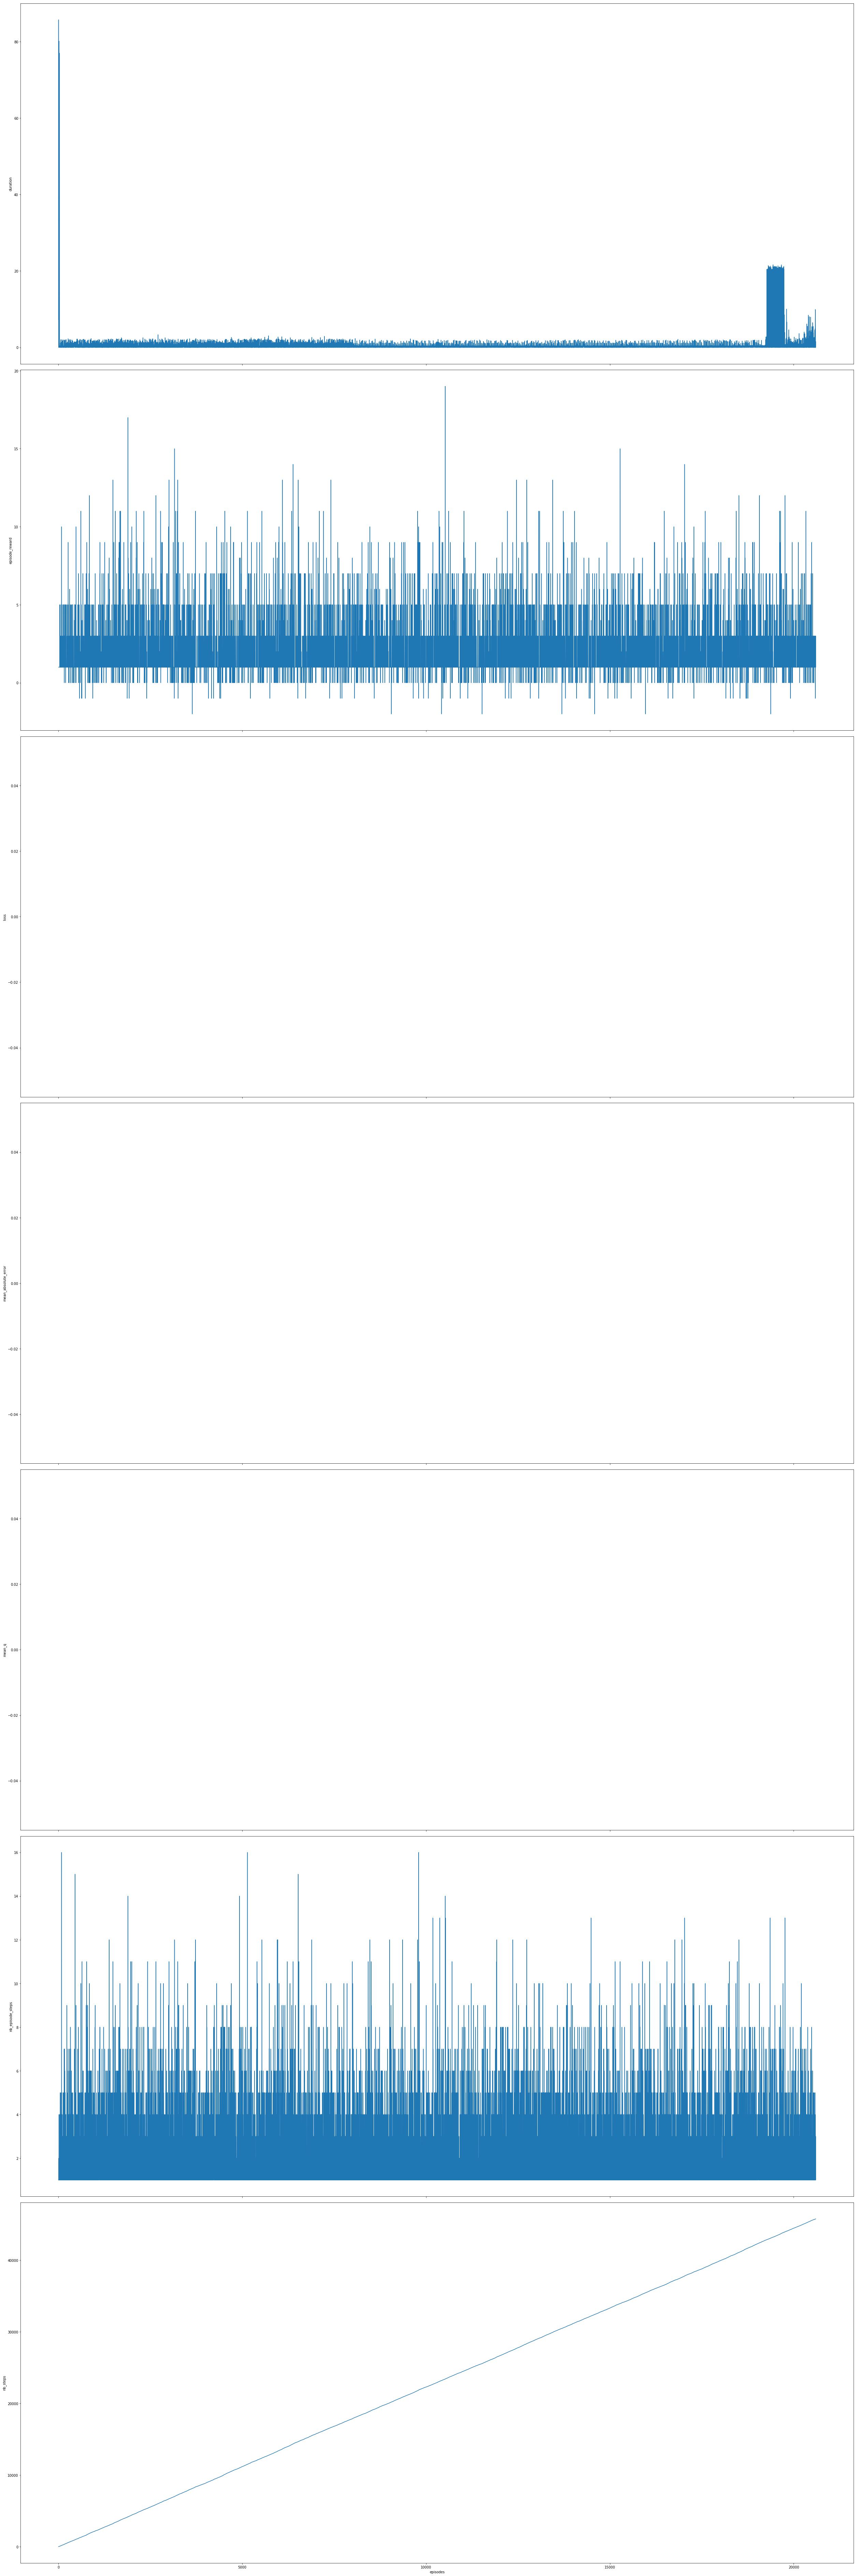

In [2]:
#visualize_log(args.filename, output=args.output, figsize=args.figsize)
visualize_log('mydqn_improvedRewardv18_log.json')
#mydqn_micro_with_swarmed_log.json

In [3]:
import pandas as pd 


In [4]:
data = pd.read_json('mydqn_improvedRewardv18_log.json')

ValueError: Expected object or value

In [ ]:
data.info

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[9.4, 8.8], dpi=150)
ax1 = fig.add_subplot(211)
t = data['nb_steps']
s1 = data['duration']
ax1.plot(t, s1, 'b-', markevery=(300,8))
ax1.set_xlabel('Number of Episodes')
ax1.set_ylabel('Reward per Episode')
ax1.grid(True)

 
fig.tight_layout()

plt.show()

In [ ]:
t = data['duration']
 

fig, ax = plt.subplots()
ax.plot(t)

ax.set(xlabel='time (s)', ylabel='duration (s)',
       title='adaptation time')
ax.grid()

fig.savefig("test.png")
plt.show()

In [ ]:
import seaborn as sns
sns.distplot(data['duration'], bins=50,  kde=True)

In [ ]:
import numpy as np
import seaborn as sns
#data = [1.5]*7 + [2.5]*2 + [3.5]*8 + [4.5]*3 + [5.5]*1 + [6.5]*8
sns.set_style('whitegrid')
sns.kdeplot(data['duration'], bw=20)

In [ ]:
t =  data['duration']
s = data['nb_steps']

fig, ax = plt.subplots()
ax.plot(s, t)

ax.grid(True, linestyle='-.')
ax.tick_params(labelcolor='b', labelsize='medium', width=3)

plt.show()

In [ ]:
 
fig = plt.figure(figsize=[9.4, 8.8], dpi=150)
ax1 = fig.add_subplot(111)
t = data['episode']
s1 = data['episode_reward']
ax1.plot(t, s1, 'b-', markevery=(30,8))
ax1.set_xlabel('Number of Episodes')
ax1.set_ylabel('Reward per Episode')
ax1.grid(True)

ax2 = ax1.twinx()
s2 = data['mean_q']
ax2.plot(t, s2, 'go--', markevery=0.1)
ax2.set_ylabel('Mean of Q value')
fig.tight_layout()

plt.show()

In [ ]:
 
fig = plt.figure(figsize=[9.4, 8.8], dpi=150)
ax1 = fig.add_subplot(111)
t = data['episode']
s1 = data['duration']
ax1.plot(t, s1, 'b-', markevery=(30,8))
ax1.set_xlabel('Number of Episodes')
ax1.set_ylabel('Adaptation time (seconds)')
ax1.grid(True)

ax2 = ax1.twinx()
s2 = data['loss']
ax2.plot(t, s2, 'r--', markevery=8)
ax2.set_ylabel('Mean of Q value')
#ax2.set_yscale()
fig.tight_layout()
plt.legend()

plt.show()

In [ ]:

data.hist(bins=50, figsize=(20,25))

In [ ]:
fig, ax = plt.subplots()
ms = data['mean_absolute_error']

ax.plot(data['nb_steps'],'-o', ms=6, lw=2, alpha=0.7, mfc='orange')
#ax.plot(np.random.rand(20), '-o', ms=20, lw=2, alpha=0.7, mfc='orange')
ax.grid()
ax.set_xlabel('Mean Q value')
#fig.figimage(10, 10, zorder=3)

plt.show()

#

In [ ]:
data['duration'].plot(kind='line', grid=True, sharex=True, legend=True, figsize=[19.4, 18.8] )

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#sns.set(style="white", palette="muted", color_codes=True)
rs = np.random.RandomState(10)

# Set up the matplotlib figure
f, axes = plt.subplots(nrows=1, ncols=1)
#sns.despine(left=True)

# Generate a random univariate dataset
d = data['duration']
d2= data['mean_absolute_error']
# Plot a simple histogram with binsize determined automatically
#sns.distplot(d, kde=False, color="b", ax=axes[0, 0])

# Plot a kernel density estimate and rug plot
#sns.distplot(d, kde=True, hist=True, rug=False, color="r", ax=axes[0])

# Plot a filled kernel density estimate
sns.distplot(d2, kde=True, hist=True, color="g", kde_kws={"shade": False}, axlabel='Mean Absolute Error (MAE) ')

# Plot a historgram and kernel density estimate
#sns.distplot(d2, color="m", ax=axes[1, 1])

plt.setp(axes, yticks=[])
plt.tight_layout()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data['duration'].plot(kind="line",  legend=True, grid=True, figsize=(40,25))

In [ ]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, expand_nested=False,  to_file='model.png')

In [ ]:
plot_model(model, show_shapes=False, expand_nested=True, rankdir='TB', to_file='model1.png')

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))